In [151]:
from os.path import join
import scipy
import numpy as np
import pandas as pd
import networkx as nx
import graph_tool.all as gt
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

import wcorr as wc
from clustering import sponge_partition
import viz_utils as viz

pd.DataFrame.wcorr = wc.wcorr

# settings
wd = join('..', '..', 'data')  # path to where data is kept and results will be saved
METRIC = 'spearman'            # Spearman or Pearson correlation (leave as Spearman)
MEASURE_STR = 'Likelihood'      # Likelihood or Potential
SIG_ONLY = False             # Only use significant correlations as edges
CIRCULAR = not SIG_ONLY

df = pd.read_csv(join(wd, 'feb_farm_data_s2.csv'))

## Contents
1. Format data
2. Functions to calculate and plot all correlation metrics, and p-values (for Spearman correlation)
3. Construct a Graph from these correlations, either using only significant edges or using all edges.
4. Calculate network communities using SPONGE

### 1. Format data

In [152]:
# create a dictionary of the criteria names and indices
criteria_df = df.head(10)[['Criterion.1', 'Unnamed: 7']].set_index('Criterion.1')
criteria_df.index.name = 'index'
criteria_df.columns = ['criterion']

# We will use these dictionaries throughout
criteria_dict = {int(val): name for val, name in zip(criteria_df.index, criteria_df['criterion'])}
C = len(criteria_dict)
criteria = [*criteria_dict.values()]
index_dict = {key: value for key, value in zip(range(C), criteria)}

# set up dataframe for each of likelihood, potential, and uncertainty
measure = df.pivot(index="Fish ID", columns="Criterion", values=MEASURE_STR)
certainty = df.pivot(index="Fish ID", columns="Criterion", values="Certainty")

# export pivoted dataframes as csvs
measure.to_csv(join(wd, f'{MEASURE_STR.lower()}.csv'))
certainty.to_csv(join(wd, 'certainty.csv'))

# have a look at what values are here
measure_unique = [*set(measure.values.ravel())]
print(f"Unique values in {MEASURE_STR}: {measure_unique}")
print(f"Unique values in Certainty: {set(certainty.values.ravel())}")

# get rid of negative values and minmax scale option
measure = measure.applymap(lambda x: np.nan if x < 0 else x)
certainty = certainty.applymap(lambda x: np.nan if x < 0 else x)
measure_z = measure / measure.max().max()  # minmax scale to [0, 1]

measure_unique = set(pd.unique(measure.values.ravel('K')))
measurez_unique = set(pd.unique(measure_z.values.ravel('K')))

# look at what unique values exist in dataframe
print(f"\nUnique values in {MEASURE_STR} after removing NaNs: {measure_unique}")
print(f"Unique values in {MEASURE_STR} after MinMax scaling: {measurez_unique}")

Unique values in Likelihood: [0, 2, -1, -2]
Unique values in Certainty: {0, 1, 2, -2}

Unique values in Likelihood after removing NaNs: {0.0, 2.0, nan}
Unique values in Likelihood after MinMax scaling: {0.0, nan, 1.0}


Now that we have formatted the data we can have a look at what the pairs look like. Each entry (i, j) in the following matrices represents the number of times first criteria has entries in i and the second criteria has entries in j.

Change any of strings below to compare the criteria. Note: likelihood only have three possible values {0.0, 2.0, nan} while Potential has four {0.0, 1.0, 2.0, nan}. More correlated feature pairs will have more values concentrated in the antidiagonal.

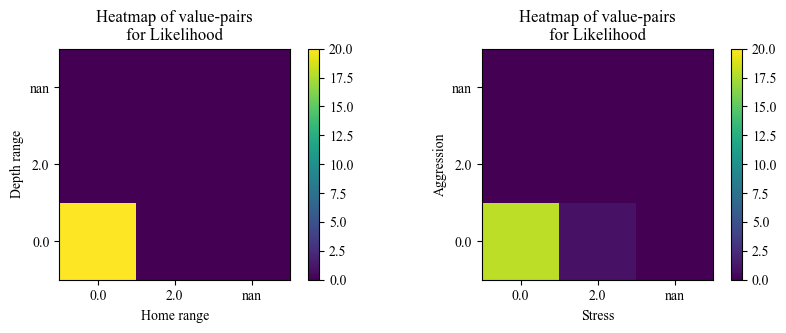

In [153]:
# inspect a single pair of criteria (change)
i, j = 'Home range', 'Depth range'
m, n = 'Stress', 'Aggression'

# plot
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
viz.plot_heatmap(measure, i, j, measure_unique, axs[0], MEASURE_STR, criteria_dict)
viz.plot_heatmap(measure, m, n, measure_unique, axs[1], MEASURE_STR, criteria_dict);

/Users/alison/Documents/FishEtho/fishetho_networks/python/wcorr.py:184: RuntimeWarning: invalid value encountered in double_scalars
  return numerator / denom
/Users/alison/miniconda3/envs/fishethobase/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Spearman correlation of Reproduction and Substrate: 0.37
Weighted Spearman correlation of Reproduction and Substrate: 0.32


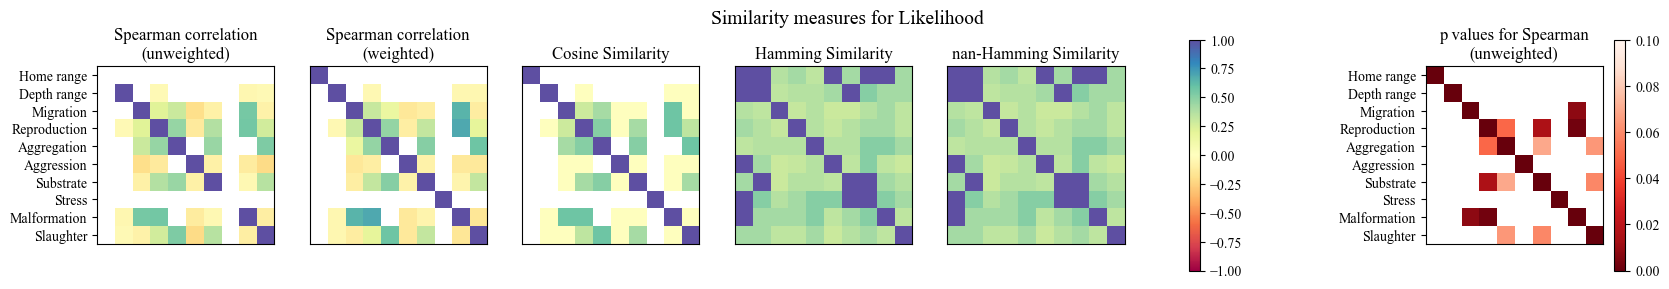

In [154]:
# plot correlation coefficients
cmap = 'Spectral'
spearman_measure = measure.corr(method=METRIC)
wspearman_measure = measure.wcorr(certainty, method=METRIC.capitalize())
pvals = measure.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*spearman_measure.shape)
cosine_measure = measure.corr(method=wc.cosine_similarity)
hamming_measure = measure_z.corr(method=wc.hamming_similarity)
nanhamming_measure = measure_z.corr(method=wc.nanhamming_similarity)

fig, axs = plt.subplots(1, 6, figsize=(20, 3))

ax = axs[0]
im = ax.imshow(spearman_measure.to_numpy(), cmap=cmap, vmin=-1, vmax=1)
ax.set_title('Spearman correlation\n(unweighted)')
ax.set_xticks([])
ax.set_yticks([*range(10)])
ax.set_yticklabels([*criteria_dict.values()], rotation=0)

ax = axs[1]
im = ax.imshow(wspearman_measure.to_numpy(), cmap=cmap, vmin=-1, vmax=1)
ax.set_title('Spearman correlation\n(weighted)')
ax.set_xticks([])
ax.set_yticks([])
ax.set_yticklabels([], rotation=0)


ax = axs[2]
im = ax.imshow(cosine_measure.to_numpy(), cmap=cmap, vmin=-1, vmax=1)
ax.set_title('Cosine Similarity')
ax.set_xticks([])
ax.set_yticks([])

ax = axs[3]
im = ax.imshow(hamming_measure, cmap=cmap, vmin=-1, vmax=1)
ax.set_title('Hamming Similarity')
ax.set_xticks([])
ax.set_yticks([])

ax = axs[4]
im = ax.imshow(nanhamming_measure, cmap=cmap, vmin=-1, vmax=1)
ax.set_title('nan-Hamming Similarity')
ax.set_xticks([])
ax.set_yticks([])

fig.colorbar(im, ax=axs[:-1].ravel().tolist())
plt.suptitle(f"Similarity measures for {MEASURE_STR}", fontsize=14);

ax = axs[-1]
pcmap = plt.cm.Reds_r
pcmap.set_over("White")
im = ax.imshow(pvals.to_numpy(), cmap=pcmap, vmin=0, vmax=0.1)
ax.set_title('p values for Spearman\n(unweighted)')
ax.set_xticks([])
ax.set_yticks([*range(10)])
ax.set_yticklabels([*criteria_dict.values()], rotation=0)
fig.colorbar(im, ax=ax);

fig.savefig(join(wd, METRIC, MEASURE_STR, f'{MEASURE_STR.lower()}.png'), dpi=400, bbox_inches='tight')

print(f"Spearman correlation of Reproduction and Substrate: {spearman_measure.loc[30, 33]:.2f}")
print(f"Weighted Spearman correlation of Reproduction and Substrate: {wspearman_measure.loc[30, 33]:.2f}")

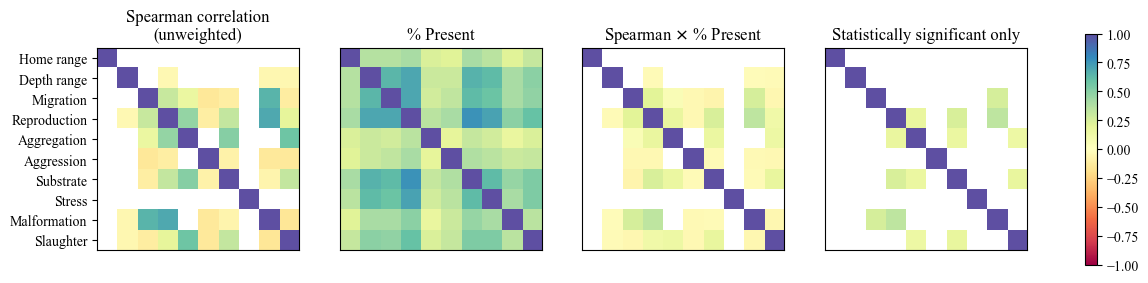

In [155]:
def perc_present(col1, col2, T=len(measure)):
    """View %data present in each pair of columns."""
    valid = np.isfinite(col1) & np.isfinite(col2)
    P = sum(valid)
    return P / T


fig, axs = plt.subplots(1, 4, figsize=(15, 3))

ax = axs[0]
im = ax.imshow(wspearman_measure, cmap=cmap, vmin=-1, vmax=1)
ax.set_title('Spearman correlation\n(unweighted)')
ax.set_xticks([])
ax.set_yticks([*range(10)])
ax.set_yticklabels([*criteria_dict.values()], rotation=0)

ax = axs[1]
perc_present = measure.corr(method=perc_present)
ax.imshow(perc_present, cmap=cmap, vmin=-1, vmax=1)
ax.set_title('% Present')
ax.set_xticks([])
ax.set_yticks([])
ax.set_yticklabels([])

ax = axs[2]
prod = wspearman_measure * perc_present
ax.imshow(prod, cmap=cmap, vmin=-1, vmax=1)
ax.set_title(r'Spearman $\times$ % Present')
ax.set_xticks([])
ax.set_yticks([])
ax.set_yticklabels([])

ax = axs[3]
sig = prod * pvals.applymap(lambda x: np.nan if x > 0.1 else 1)
ax.imshow(sig, cmap=cmap, vmin=-1, vmax=1)
ax.set_title(r'Statistically significant only')
ax.set_xticks([])
ax.set_yticks([])
ax.set_yticklabels([])

plt.colorbar(im, ax=axs.ravel().tolist());

fig.savefig(join(wd, METRIC, MEASURE_STR, f'{MEASURE_STR.lower()}_percpresent.png'), dpi=400)

# Make network
We can create the network, where edges where the correlations are not significant are set to weight 0, if the SIG_ONLY flag is set to True. The communities detected are quite limited with the significance filter as only a few edges remain. It is equally useful to just inspect the network and visualise which nodes have significant edges. As more observations become available it is likely that more edges will become significant making this measure more useful.

In [156]:
corrs = wspearman_measure.copy(deep=True)
METRIC = 'spearman'

# Get the upper-triangular indices
triu_indices = np.triu_indices(C, k=1)

# Get the values from the dataframes
corr_values = corrs.values[triu_indices]
present_values = perc_present.values[triu_indices]
p_values = pvals.values[triu_indices]

# Compute the weights
weights = {}
for k in range(len(corr_values)):
    i, j = triu_indices[0][k], triu_indices[1][k]
    corr = corr_values[k]
    present = present_values[k]
    if SIG_ONLY:
        pval = p_values[k]
    else:
        pval = 0.
    
    if (not np.isnan(corr)) & (pval < 0.1):
        weights[(i, j)] = corr * present

# define edge weights using a dict
nodes = [x for x in range(len(corrs))]
edges = {(tup[0], tup[1], weight, np.sign(weight), 10 * abs(weight)) for tup, weight in weights.items()}  # set

# create a networkx Graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from([(edge[0], edge[1], edge[2]) for edge in edges])

A = nx.adjacency_matrix(G).todense()
np.savetxt(join(wd, METRIC, MEASURE_STR.lower(), 'adjacency_weighted.csv'), A, delimiter=",")



/var/folders/7w/k72v6f5x25gblsqmh6bxd3j40000gn/T/ipykernel_35499/3975718309.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).todense()


In [157]:
nconnected = nx.number_connected_components(G)

K = nconnected if nconnected > 3 else 3

# calculate partition using the SPONGE method
community_dict = sponge_partition(G, K, tau_plus=10)

/Users/alison/miniconda3/envs/fishethobase/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [158]:
edgewidth = 1


# create a graph_tool Graph for better visualisation
g = gt.Graph(directed=False)
weight = g.new_ep("double")
absweight = g.new_ep("double")
sign = g.new_ep("double")

# add edge attributes
g.add_edge_list(edges, eprops=[weight, sign, absweight])
g.ep['weight'] = weight

# add vertex properties
name = g.new_vp("string") 
community = g.new_vp('int')
plot_color = g.new_vp('vector<double>')

#set the value to the vertex property
for node in range(C):
    name[node] = index_dict[node]
    community[node] = community_dict[node]

#assign properties as a dict value
g.vertex_properties["name"] = name 
g.vertex_properties['plot_color'] = plot_color

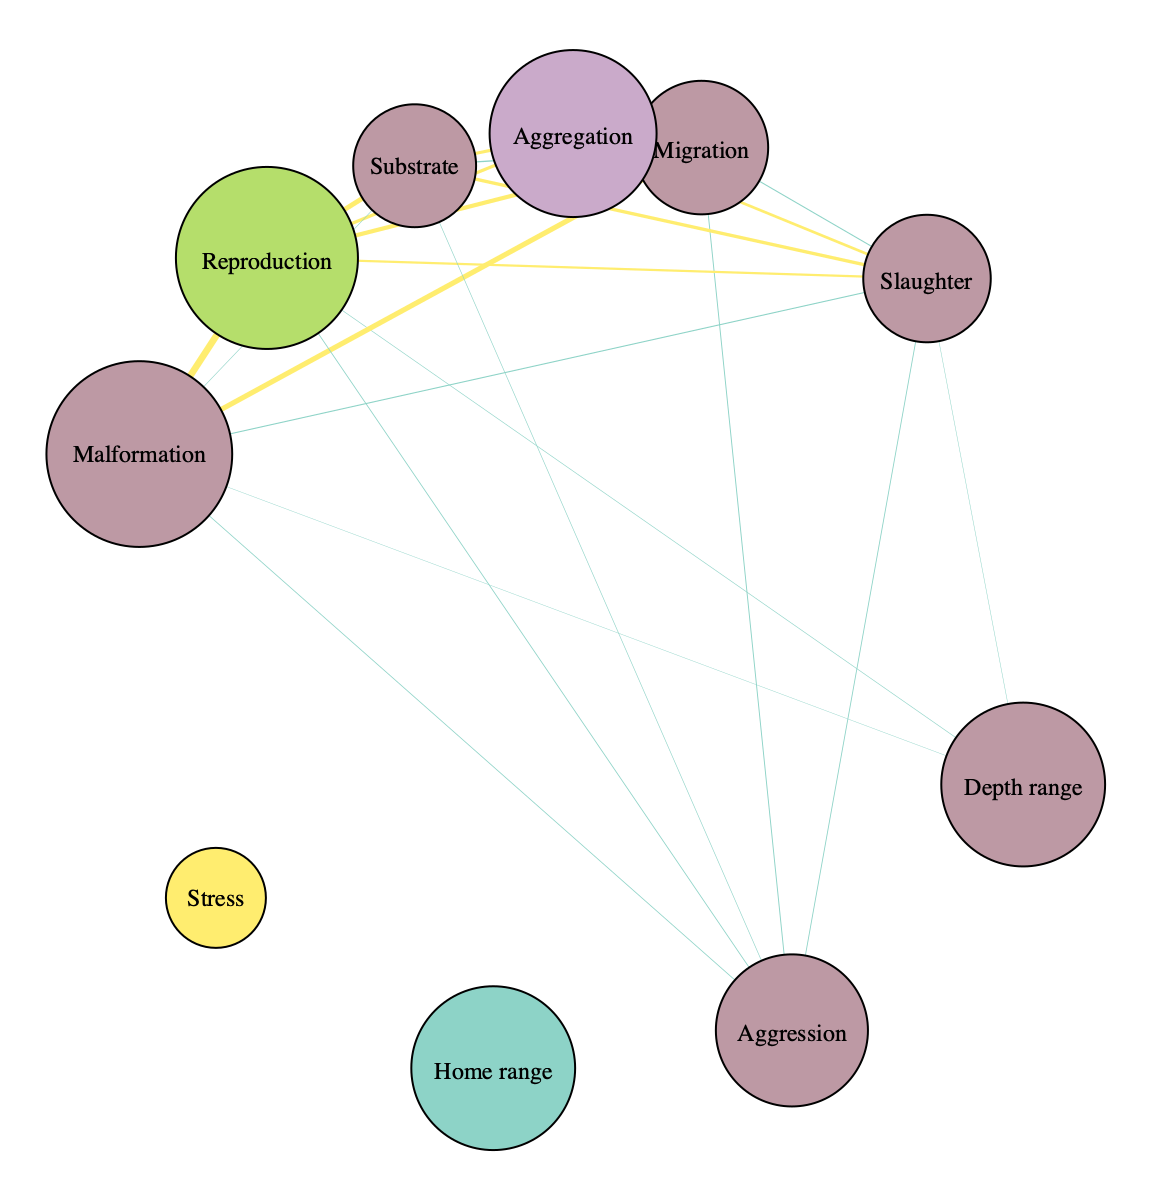

In [159]:
# visualise
pos = gt.fruchterman_reingold_layout(g, weight=weight, circular=CIRCULAR, n_iter=1000, a=2)

if True:
    EXPORT = False
    if EXPORT:
        if SIG_ONLY:
            impath = join(wd, METRIC, MEASURE_STR, 'sponge.png')
        else:
            impath = join(wd, METRIC, MEASURE_STR, 'sponge_significant.png')
    else:
        impath = None

    gt.graph_draw(g, pos,
                  vertex_size=50, vertex_text=name, vertex_font_size=12, vertex_shape="circle",
                  vertex_text_color="black", vertex_color="black", vertex_fill_color=community,
                  vertex_pen_width=1, vertex_halo=True, vertex_halo_size=1,
                  edge_color=sign, edge_pen_width=absweight,
                  output=impath, fit_view_ink=True)

In [160]:
K

3